http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb

https://prateekvjoshi.com/2016/02/23/deep-learning-with-caffe-in-python-part-iv-classifying-an-image/

In [15]:
import numpy as np
import pandas as pd
import math
import os
from scipy.misc import imread

import caffe
caffe.set_mode_cpu()

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
images_dir="../Data/google_image_matching_lsms/"

In [17]:
#Weights and Model come from Neal Jean Github Repo : https://github.com/nealjean/predicting-poverty
model_file = '../Caffe_Model/predicting_poverty_deploy.prototxt'
weights_file = '../Caffe_Model/predicting_poverty_trained.caffemodel'
net = caffe.Net(model_file, weights_file, caffe.TEST)

In [18]:
#Intermediary Layer 
layer='conv7'

In [19]:
mu = np.array([103.334, 107.8797, 107.4072])

# Test with One image

In [20]:
img_path = '../Data/google_image_matching/0/25628_8684.jpg'

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.11 ms


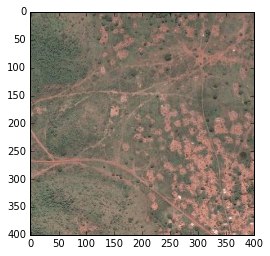

In [21]:
%time
image = caffe.io.load_image(img_path)
plt.imshow(image)

In [22]:
image.shape

(400, 400, 3)

In [24]:
%time

transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255.0)      # rescale from [0, 1] to [0, 255]


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


In [25]:
%time
net.blobs['data'].reshape(1,3,400, 400)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 119 µs


In [26]:
%time
image_preprocess= transformer.preprocess('data', image)

CPU times: user 0 ns, sys: 10 ms, total: 10 ms
Wall time: 20 µs


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 26.9 µs


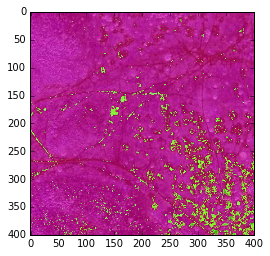

In [27]:
%time
plt.imshow(image_preprocess.transpose(1,2,0))

In [28]:
%time
# copy it into the net
net.blobs['data'].data[...] = image_preprocess

# perform classification
out = net.forward()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 37.9 µs


In [29]:
%time
# obtain the features
features = net.blobs[layer].data[0]
features.shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 69.9 µs


(4096, 2, 2)

In [30]:
%time
f, h, w = features.shape
features = features.reshape(f, h*w)
features.shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


(4096, 4)

In [31]:
%time
features = np.mean(features, axis=1)
features.shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16 µs


(4096,)

# All images with 1 image per cluster

In [48]:
Final=pd.DataFrame([])

In [6]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

In [7]:
net.blobs['data'].reshape(1,3,400, 400)

In [36]:
i=0
for root, dirs, files in os.walk(images_dir):
    for name in files:
        if name.endswith(".jpg") : 
            i+=1
            print(i)
            img_path = os.path.join(root, name)
            
            image = caffe.io.load_image(img_path)
            

            
            image_preprocess= transformer.preprocess('data', image)
            net.blobs['data'].data[...] = image_preprocess
            
            out = net.forward()
            
            features = net.blobs[layer].data[0]
            f, h, w = features.shape
            features = features.reshape(f, h*w)
            features = np.mean(features, axis=1)
            
            Final[name]=features

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [37]:
Final.shape

(4096, 308)

In [38]:
Final=Final.transpose().reset_index()
Final["i"]=Final["index"].str.slice(0,5)
Final["j"]=Final["index"].str.slice(6,10)

Final["i"]=pd.to_numeric(Final["i"])
Final["j"]=pd.to_numeric(Final["j"])
Final.head()

,index,0,1,2,3,4,5,6,7,8,...,4088,4089,4090,4091,4092,4093,4094,4095,i,j
0,25158_9094.jpg,0.316197,0.000000,0.000000,0.162693,0.477875,0.019161,0.466228,0.000000,0.011709,...,0.0,1.200203,0.170876,0.604885,0.074611,0.099342,0.111368,0.00000,25158,9094
1,25161_9138.jpg,0.445743,0.010201,0.044694,0.148796,0.445563,0.009494,0.273425,0.000000,0.280718,...,0.0,0.706125,0.201996,0.390387,0.033541,0.074433,0.234463,0.00000,25161,9138
2,25168_9000.jpg,0.680378,0.178718,0.314129,0.763553,0.686220,0.160707,0.534167,0.064197,1.429371,...,0.0,1.079899,0.000000,0.440434,0.520385,0.147103,0.671137,0.00000,25168,9000
3,25172_9161.jpg,0.471362,0.157777,0.000000,0.138971,0.309003,0.010231,0.208968,0.000000,0.263752,...,0.0,0.699581,0.187913,0.292849,0.056544,0.058052,0.370715,0.01839,25172,9161
4,25173_9108.jpg,0.067380,0.000000,0.090417,0.478733,0.505827,0.000000,0.430971,0.000000,0.227305,...,0.0,0.966589,0.074235,0.463077,0.059523,0.077011,0.107176,0.00000,25173,9108


In [39]:
Final.to_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGGF_caffe_conv7_mean.csv")

# All images with 100 images per cluster

In [20]:
images_dir="../Data/googleimage_matchinglsms_10percluster/"

In [21]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

In [22]:
net.blobs['data'].reshape(1,3,400, 400)

In [23]:
def Average_features_dir(image_dir):
    i=0
    features_df=pd.DataFrame([])
    
    for name in os.listdir(image_dir):
        if name.endswith(".jpg") : 
            img_path = os.path.join(image_dir, name)
            image = caffe.io.load_image(img_path)
            image_preprocess= transformer.preprocess('data', image)
            net.blobs['data'].data[...] = image_preprocess
            
            out = net.forward()
            
            features = net.blobs[layer].data[0]
            f, h, w = features.shape
            features = features.reshape(f, h*w)
            features = np.mean(features, axis=1)
            
            features_df[name]=features
            avg_features=features_df.mean(axis=1)

    return avg_features

In [25]:
i=0
Final=pd.DataFrame([])
for name in os.listdir(images_dir):
    i+=1
    if len(name)==10:
        print(i)
        Final[name]=Average_features_dir(os.path.join(images_dir, name))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [26]:
Final.shape

(4096, 308)

In [27]:
Final=Final.transpose().reset_index()
Final["i"]=Final["index"].str.slice(0,5)
Final["j"]=Final["index"].str.slice(6,10)

Final["i"]=pd.to_numeric(Final["i"])
Final["j"]=pd.to_numeric(Final["j"])
Final.head()

,index,0,1,2,3,4,5,6,7,8,...,4088,4089,4090,4091,4092,4093,4094,4095,i,j
0,25158_9094,0.261871,0.006326,0.006357,0.160696,0.359172,0.012751,0.418719,0.000896,0.031268,...,0.000000,1.094436,0.154491,0.510368,0.047493,0.122196,0.098898,0.010278,25158,9094
1,25161_9138,0.290668,0.060667,0.010910,0.162699,0.341811,0.034813,0.381344,0.020331,0.116457,...,0.000237,0.850969,0.190978,0.356362,0.049978,0.099518,0.122829,0.053453,25161,9138
2,25168_9000,0.333238,0.045546,0.057839,0.260954,0.386827,0.045438,0.466479,0.021406,0.247408,...,0.001124,0.912010,0.135360,0.390948,0.116204,0.138974,0.188204,0.029600,25168,9000
3,25172_9161,0.262870,0.081398,0.012684,0.190422,0.308329,0.045846,0.331663,0.030801,0.122497,...,0.000000,0.736051,0.185541,0.344004,0.043975,0.075466,0.133451,0.061188,25172,9161
4,25173_9108,0.277434,0.034823,0.005626,0.167248,0.395010,0.022784,0.324976,0.009603,0.062217,...,0.000000,0.962881,0.154499,0.414859,0.031446,0.100104,0.114424,0.019573,25173,9108


In [28]:
Final.to_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGGF_caffe_conv7_mean_100imagescluster.csv")